# **Dermal Diagnostic Help - подход глубокого обучения для диагностики рака кожи**
**Рак кожи** - распространенное злокачественное заболевание, которое часто диагностируется визуально с помощью клинических осмотров и дермоскопического анализа. Набор данных HAM10000, включающий 10 015 дерматоскопических изображений, позволяя разработать автоматизированную систему классификации поражений кожи.

**"Dermal Diagnostic Help"** - инновационное приложение, разработанное для помощи в ранней диагностике рака кожи с использованием методов глубокого обучения. Используя датасет HAM10000, этот проект нацелен на создание точной и эффективной модели для классификации кожных образований.



---


Модель фокусируется на обнаружении семи различных классов рака кожи.

**Классы рака кожи:**
- Меланоцитарные невусы (nv)
- Меланома (mel)
- Доброкачественные кератозоподобные образования (bkl)
- Базальноклеточный карцинома (bcc)
- Актинические кератозы (akiec)
- Сосудистые образования (vasc)
- Дерматофиброма (df)

Каждое из заболеваний в HAM10000 датасете имеет свои характерные черты, которые описываются в статье. Вот краткое описание каждого заболевания:

- **nv (Melanocytic nevi):**
Беневольные новообразования меланоцитов, включающие различные варианты. 6705 изображений.

- **mel (Melanoma):**
Злокачественное новообразование, происходящее от меланоцитов.
Включает различные варианты меланомы, как инвазивные, так и неинвазивные (in situ). Исключаются не пигментированные, субунгуальные, глазные или слизистые меланомы. 1113 изображений.

- **bkl (Benign keratosis):**
Обобщенный класс, включающий себорейные кератозы ("старческие бородавки"), солярные лентиго (плоский вариант себорейных кератозов) и кератозы, похожие на лишай планус (LPLK), которые могут соответствовать себорейному кератозу или солярному лентиго с воспалением и регрессией. Эти подгруппы могут выглядеть по-разному дерматоскопически, но они группируются вместе из-за их схожей биологии и часто отмечаются одним и тем же термином при гистопатологическом исследовании. 1099 изображений.

- **bcc (Basal cell carcinoma):**
Распространенный вариант эпителиального рака кожи, который редко метастазирует, но разрушает ткани, если не лечить. Появляется в различных морфологических вариантах (плоский, узловой, пигментированный, кистозный и др.). 514 изображений.

- **akiec (Actinic Keratoses and intraepithelial Carcinoma):**
Общие неинвазивные варианты плоскоклеточного рака, которые могут быть вылечены местно без хирургического вмешательства. Некоторые авторы рассматривают их как предшественников плоскоклеточных раков, а не как реальный рак. Оба непрерывно демонстрируют образование корки на поверхности и обычно лишены пигмента. 327 изображений.

- **vasc (Vascular skin lesions):**
Сосудистые образования от гемангиом до ангиокератом и пиогенных гранулем.
Включает геморрагии. 142 изображения.

- **df (Dermatofibroma):**
Беневольное кожное образование, рассматриваемое как либо как доброкачественная пролиферация, либо как воспалительная реакция на минимальную травму. Часто коричневого цвета с центральной зоной фиброза дерматоскопически. 115 изображений.

План:
1. Импорт основных библиотек
2. Словарь изображений
3. Чтение и обработка данных
4. EDA и очистка данных


# 1. Импорт основных библиотек

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Импортируем необходимые библиотеки
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)

# 2. Словарь изображений:

In [3]:
# Задаем пути к двум архивам
base_skin_dir = '/content/drive/MyDrive/ITMO/DE/zip'

In [4]:
# Объединяем изображения из двух папок HAM10000_images_part1.zip и HAM10000_images_part2.zip в один словарь

data_dir1 = '/content/drive/MyDrive/ITMO/DE/data/data_1'
data_dir2 = '/content/drive/MyDrive/ITMO/DE/data/data_2'

# Список всех путей к изображениям в обеих папках
all_image_paths = glob(os.path.join(data_dir1, '*.jpg')) + glob(os.path.join(data_dir2, '*.jpg'))

# Создание словаря imageid_path_dict
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_paths}


In [5]:
# Словарь кратких обозначений
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

Создается словарь, в котором ключами являются идентификаторы изображений (имена файлов без расширения), а значениями - полные пути к соответствующим изображениям.

Этот словарь imageid_path_dict будет полезен для дальнейшей обработки и анализа данных, например, при подготовке данных для обучения модели машинного обучения. Каждому изображению присваивается уникальный идентификатор, и соответствующий ему путь в файловой системе сохраняется в словаре.

# 3. Чтение и обработка даннных

In [6]:
# Чтение данных из CSV-файла
skin_df = pd.read_csv(os.path.join(base_skin_dir, '/content/drive/MyDrive/ITMO/DE/HAM10000_metadata.csv'))

# Создание новых столбцов для лучшей читаемости

# Столбец, содержащий путь к изображению
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)

# Столбец, содержащий полное название типа поражения
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)

# Посмотрим на пример данных
skin_df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ITMO/DE/data/data_1/ISI...,Benign keratosis-like lesions
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ITMO/DE/data/data_1/ISI...,Benign keratosis-like lesions
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ITMO/DE/data/data_1/ISI...,Benign keratosis-like lesions
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ITMO/DE/data/data_1/ISI...,Benign keratosis-like lesions
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/ITMO/DE/data/data_2/ISI...,Benign keratosis-like lesions


В таблице содержатся данные о локализации поражения, краткое и полное название типа поражения, пол и возраст пациента, а также вид диагностики.


In [7]:
# Получение количества значений для каждого класса
class_counts_idx = skin_df['dx'].value_counts()

# Печать результатов
print(class_counts_idx)

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64



---

В данных наблюдается большой дисбаланс классов, который может привести к:

1. **Смещение в сторону преобладающего класса:** Модель может склоняться к предсказанию класса, который встречается чаще в обучающем наборе данных. Это связано с тем, что оптимизация модели стремится минимизировать общий функционал потерь, и в случае дисбаланса модель может просто предсказывать наиболее часто встречающийся класс, что снижает ее способность к обобщению.

2. **Понижение точности для меньшинственного класса:** Метрики, такие как точность (accuracy), могут быть обманчивыми при дисбалансе классов. Даже если модель просто предсказывает преобладающий класс, она может достичь высокой точности, но при этом ее способность к предсказанию меньшинственного класса будет низкой.

3. **Затруднение обучения:** Модель может испытывать затруднения в обучении из-за дисбаланса классов.

Решение - использовать методы аугментации данных для увеличения размера обучающего набора для меньших классов.


---

# 4. EDA и очистка данных

In [8]:
# Смотрим количество строк и столбцов
skin_df.shape

(10015, 9)

In [9]:
# Смотрим общую информацию
skin_df.info

<bound method DataFrame.info of          lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                               

In [10]:
# Считаем количество пропущенных значений для каждого признака
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
path             0
cell_type        0
dtype: int64

In [11]:
# Выводим типы данных для каждого признака
print(skin_df.dtypes)

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
path             object
cell_type        object
dtype: object


<Axes: >

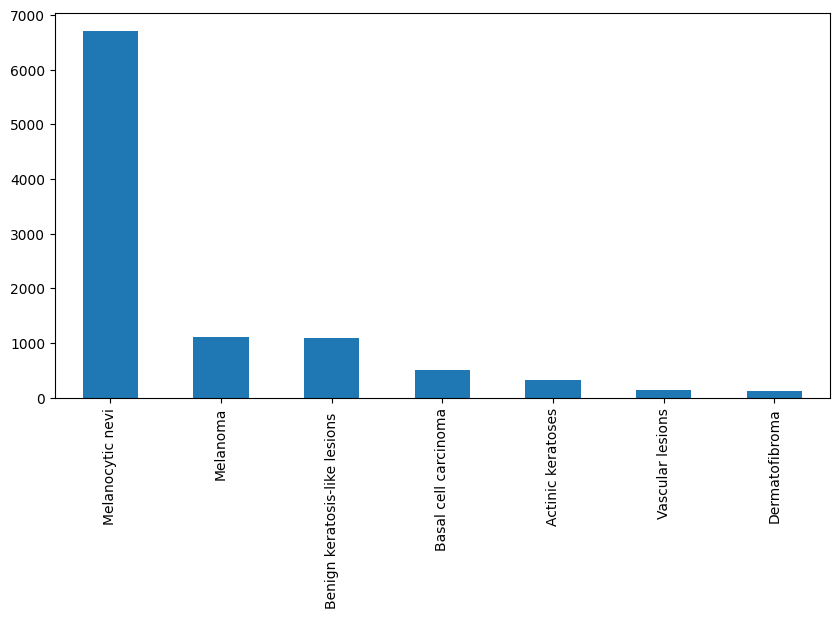

In [12]:
# Построение графика распределения 7 различных классов
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

График показывает относительное количество каждого типа клеток. Наиболее распространенным оказывается Melanocytic nevi (меланоцитарные невусы) - что и приводит к дисбалансу классов.

<Axes: >

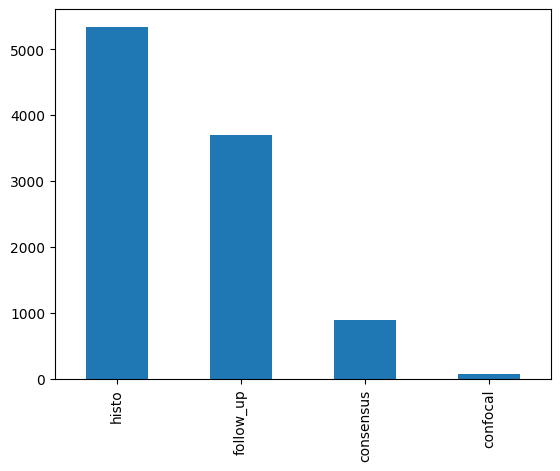

In [13]:
# Построение графика распределения поля 'dx_type'
skin_df['dx_type'].value_counts().plot(kind='bar')

Данный график представляет собой распределение типов постановки диагноза, включая гистопатологию, конфокальную микроскопию, последующих обследований или заключений экспертов. Мы видим, что более половины диагнозов были поставлены при помощи гистопатологии.

<Axes: >

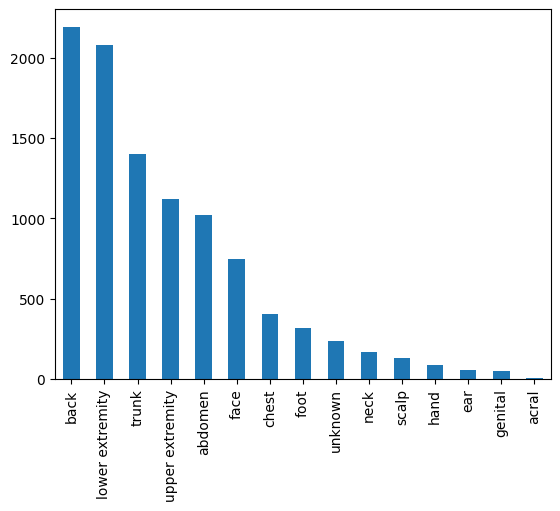

In [14]:
# Построение графика распределения поля 'localization'
skin_df['localization'].value_counts().plot(kind='bar')

График отражает, какие области кожи чаще всего подвержены различным видам рака. Наиболее часто затрагиваются области спины, нижних конечностей, туловища и верхних конечностей.

<Axes: >

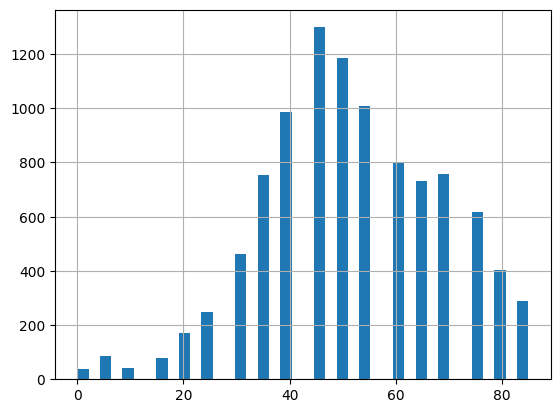

In [15]:
# Построение графика распределения возраста:
skin_df['age'].hist(bins=40)

Гистограмма предоставляет информацию о распределении возрастов пациентов, страдающих раком кожи. Наибольшее количество случаев приходится на пациентов в возрасте от 30 до 60 лет.

У нас получилось 57 пустых значений для данного столбца, а так как распределение не совсем нормальное, то заменять их будем на медианные значения, а не средние.



In [16]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [17]:
skin_df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
path            0
cell_type       0
dtype: int64

<Axes: xlabel='age', ylabel='cell_type'>

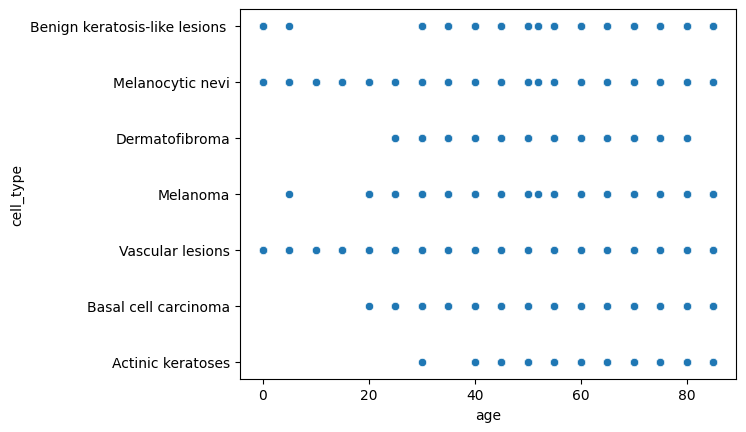

In [19]:
# Визуализация распределения типов рака кожи по возрасту:
sns.scatterplot(x='age',y='cell_type',data=skin_df)

Точечный график позволяет увидеть, как распределены различные типы рака кожи в зависимости от возраста. Например, типы 0, 1, 3 и 5 реже встречаются у лиц младше 20 лет.

### Предобработка данных

Разделение данных на тестовую, обучающую и валидационные выборки проводилось при помощи Roboflow.

Дисбаланс классов был исправлен при помощи аугментации, которая применялась к классам с меньшей выборкой.